<a href="https://colab.research.google.com/github/Louvivien/letthemlive/blob/reading_images_feature/Copia_de_blip2_instructed_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Large RAM is required to load the larger models. Running on GPU can optimize inference speed.

In [2]:
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install salesforce-lavis

Running in Colab.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 25.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 29.9 MB/s eta 0:00:0

In [1]:
import torch
from PIL import Image
import requests
from lavis.models import load_model_and_preprocess

#### Load an example image

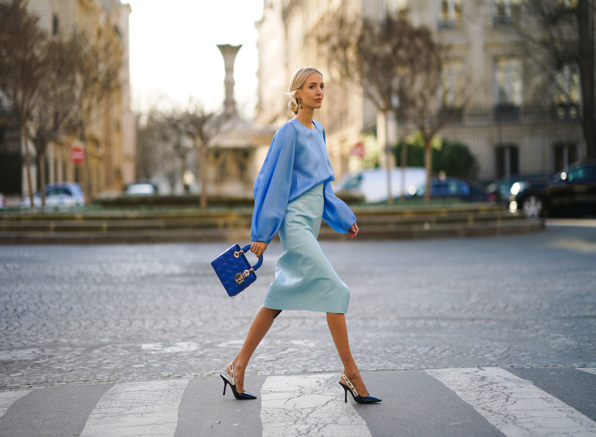

In [2]:
img_url = 'https://cdn.discordapp.com/attachments/1129065586941505657/1132046923038212167/leonie-hanne-wears-a-blue-silky-lustous-blouse-with-puff-news-photo-1689171696.jpeg'
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
display(raw_image.resize((596, 437)))

In [3]:
# setup device to use
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

#### Load pretrained/finetuned BLIP2 captioning model

In [4]:
# we associate a model with its preprocessors to make it easier for inference.
model, vis_processors, _ = load_model_and_preprocess(
    name="blip2_t5", model_type="pretrain_flant5xxl", is_eval=True, device=device
)

# Other available models:
#
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="pretrain_opt2.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="pretrain_opt6.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="caption_coco_opt2.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="caption_coco_opt6.7b", is_eval=True, device=device
# )
#
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_t5", model_type="pretrain_flant5xl", is_eval=True, device=device
# )
#
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_t5", model_type="caption_coco_flant5xl", is_eval=True, device=device
# )

vis_processors.keys()

100%|██████████| 1.89G/1.89G [01:33<00:00, 21.7MB/s]


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 413M/413M [00:20<00:00, 21.1MB/s]


dict_keys(['train', 'eval'])

#### prepare the image as model input using the associated processors

In [5]:
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)

#### generate caption using beam search

In [6]:
model.generate({"image": image})

['a woman in a blue blouse and skirt crossing the street']

#### generate multiple captions using nucleus sampling

In [7]:
# due to the non-determinstic nature of necleus sampling, you may get different captions.
model.generate({"image": image}, use_nucleus_sampling=True, num_captions=3)

['a woman in a blue blouse and skirt crossing the street',
 'a woman crossing the street in a blue blouse and skirt',
 'a woman crossing the street in a blue blouse and skirt']

#### instructed zero-shot vision-to-language generation

In [8]:
model.generate({"image": image, "prompt": "Question: Describe the image Answer:"})

['a blonde woman in a blue blouse and skirt crossing a street in paris']

In [14]:
model.generate({
    "image": image,
    "prompt": "where is she? Answer: . why: ?"})

['paris fashion week']

In [10]:
model.generate({
    "image": image,
    "prompt": "Question: Which bag does she use? Answer: . Question: why?"})

["because it's the right color for her outfit"]

In [ ]:
context = [
    ("which city is this?", "singapore"),
    ("why?", "it has a statue of a merlion"),
]
question = "where is the name merlion coming from?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

print(prompt)

Question: which city is this? Answer: singapore. Question: why? Answer: it has a statue of a merlion. Question: where is the name merlion coming from? Answer:


In [ ]:
model.generate(
    {
    "image": image,
    "prompt": prompt
    },
    use_nucleus_sampling=False,
)

['merlion is a portmanteau of mermaid and lion']